# Example linear regression model using Bayesian inference

A linear regression model is defined as

$$
y_t \sim N(\beta_0 + \beta_1 x, \sigma^2)
$$
where $y_t$ is the modelled quantity of interest (TSS), x is the predictor variable (NTU), $\beta_0$, $\beta_1$, and $\sigma$ are unknown quantities that we wish to infer. $N(\mu,\sigma^2)$ represents a normal distribution with a mean, $\mu$ and standard deviation, $\sigma$. The linear regression model is the mean process. The inference is performed using an MCMC sampler with `pymc3`.

PyMC3 uses Bayesian statistics to find distributions on model parameters i.e.,
$$
p(parameters | data) \propto p(data | parameters) \times p(parameters)
$$
In words this says the probability of the parameters given the data (the posterior distribution) is proportional to the probability of the data given the model parameters (the likelihood) times the probability of the parameters (the prior belief).


In [99]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from theano import shared

In [100]:
%matplotlib notebook

In [101]:
# Load the data
infile = './In-situ_LISST_2031_RS2019.pkl'
with open(infile,'rb') as f:
    data = pickle.load(f)
data.head()

,Bottle_conc,LISST_conc
0,43.870968,174.562467
1,27.227414,60.514467
2,6.333333,25.576267
3,7.518797,25.401767
4,10.816327,82.618767


<IPython.core.display.Javascript object>


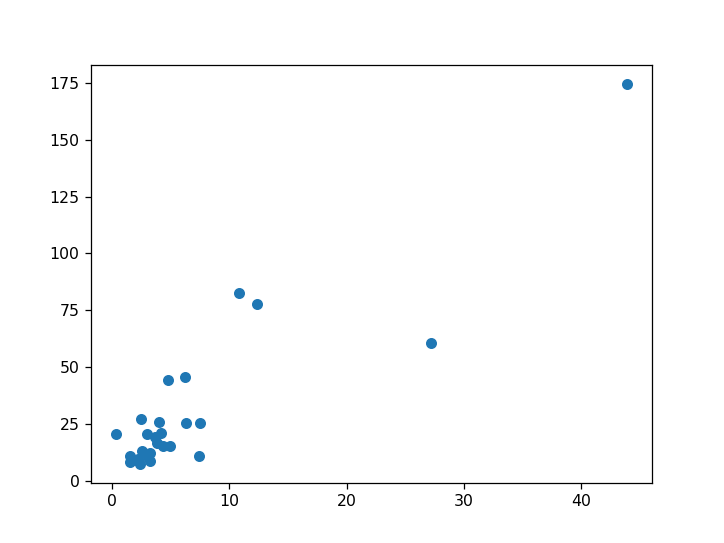

In [102]:
# Scatter plot of the data
x = data['Bottle_conc']
y = data['LISST_conc']

plt.figure()
plt.plot(x,y,'o')

<IPython.core.display.Javascript object>


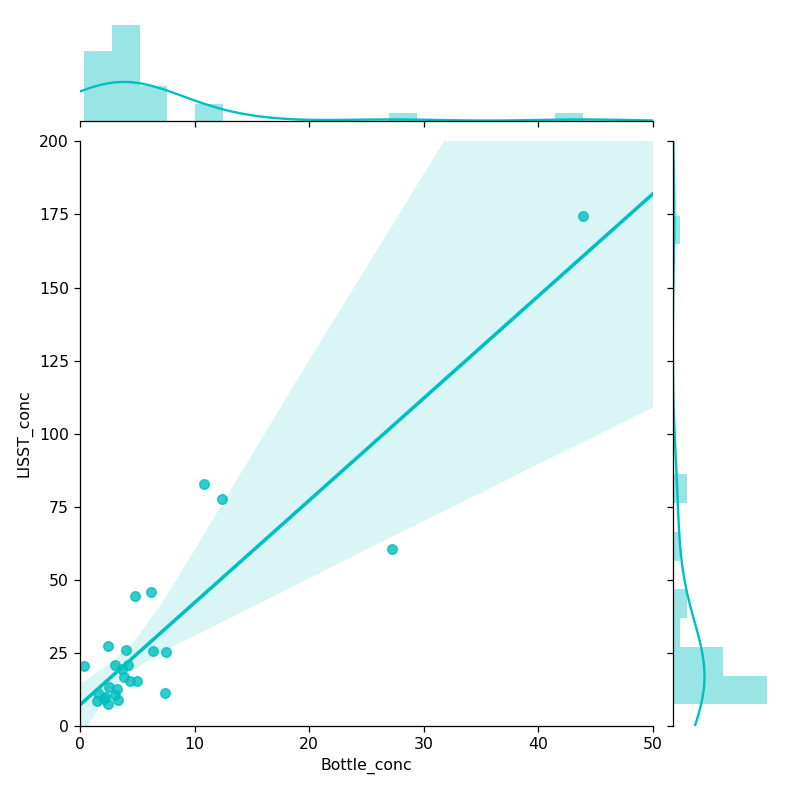

In [106]:
# Use seaborn to make a fancy "stats" plot of the data
g = sns.jointplot('Bottle_conc', 'LISST_conc', data=data, kind="reg",
                  xlim=(0, 50), ylim=(0, 200), color="c", height=7)



In [96]:
# Convert the import data from numpy to theano.tensor types
yin = shared(y.values)
xin = shared(x.values)

with pm.Model() as model:
    
    # Define the priors on the parameters i.e., p(parameters)
    beta_0 = pm.TruncatedNormal('beta_0',mu=0,sigma=1,lower=0) # Intercept with lower bound
    beta_1 = pm.Normal('beta_1',3,3) # Slope 
    sigma = pm.HalfNormal('sigma',5)
    
    # DEfine the mean function (linear regression)
    mu = beta_0 + beta_1*xin
    #mu = beta_1*xin # No intercept model

    
    # Define the model for the likelihood i.e., p(data | parameters) (this is where we input the data)
    y_t = pm.Normal('y_t',mu, sigma, observed=yin)
    #y_t = pm.Gamma('y_t',mu=mu, sd=sigma, observed=yin)

    # Do the inference
    trace = pm.sample(500, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1240.18draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


<IPython.core.display.Javascript object>


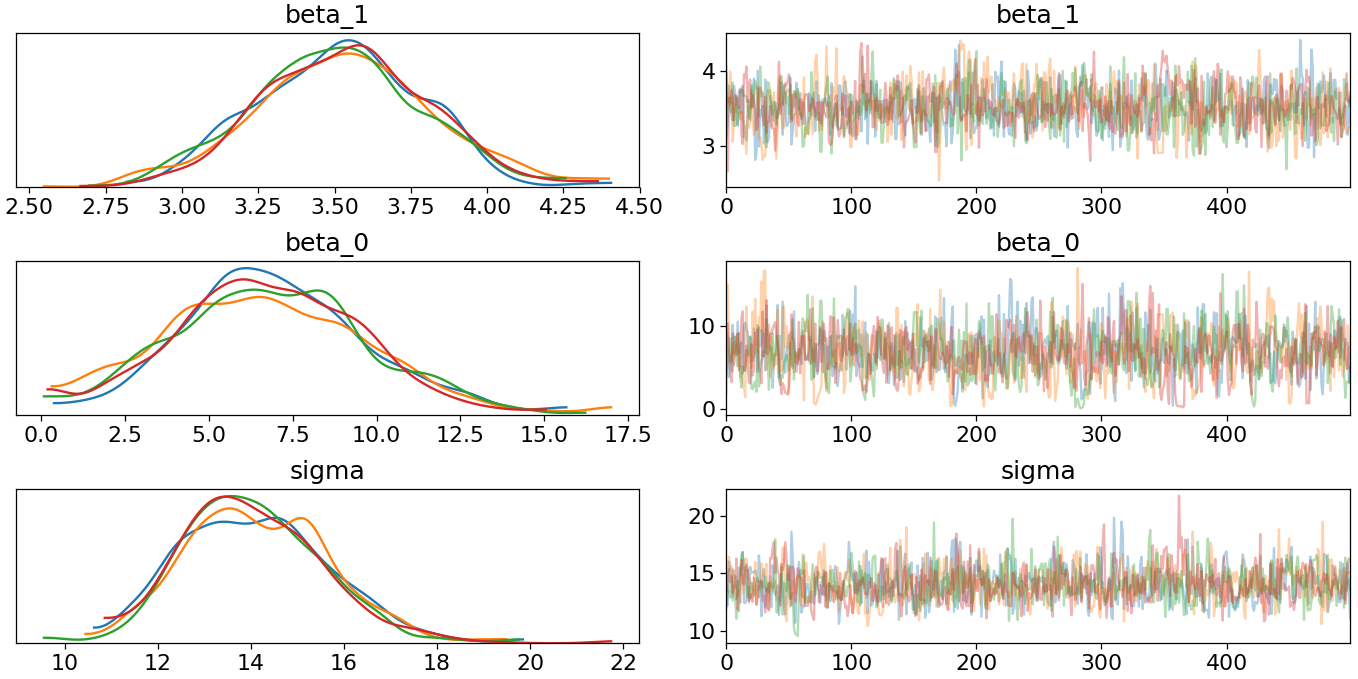

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_1,3.520312,0.277170,0.009081,2.982687,4.055218,857.122972,1.000709
beta_0,6.795890,2.876268,0.095434,1.179326,12.418315,827.829564,1.000139
sigma,14.068083,1.515698,0.046928,11.191016,16.912048,1192.923189,0.999849


In [91]:
#plots on the left show the posterior distributions of each unknown parameter
# Plots on the right are trace plots - they should jump around when the mcmc sampling is working
pm.traceplot(trace)
# Summary prints out the details about each parameter
# n_eff and Rhat indicate how well the mcmc went
pm.summary(trace)

<IPython.core.display.Javascript object>


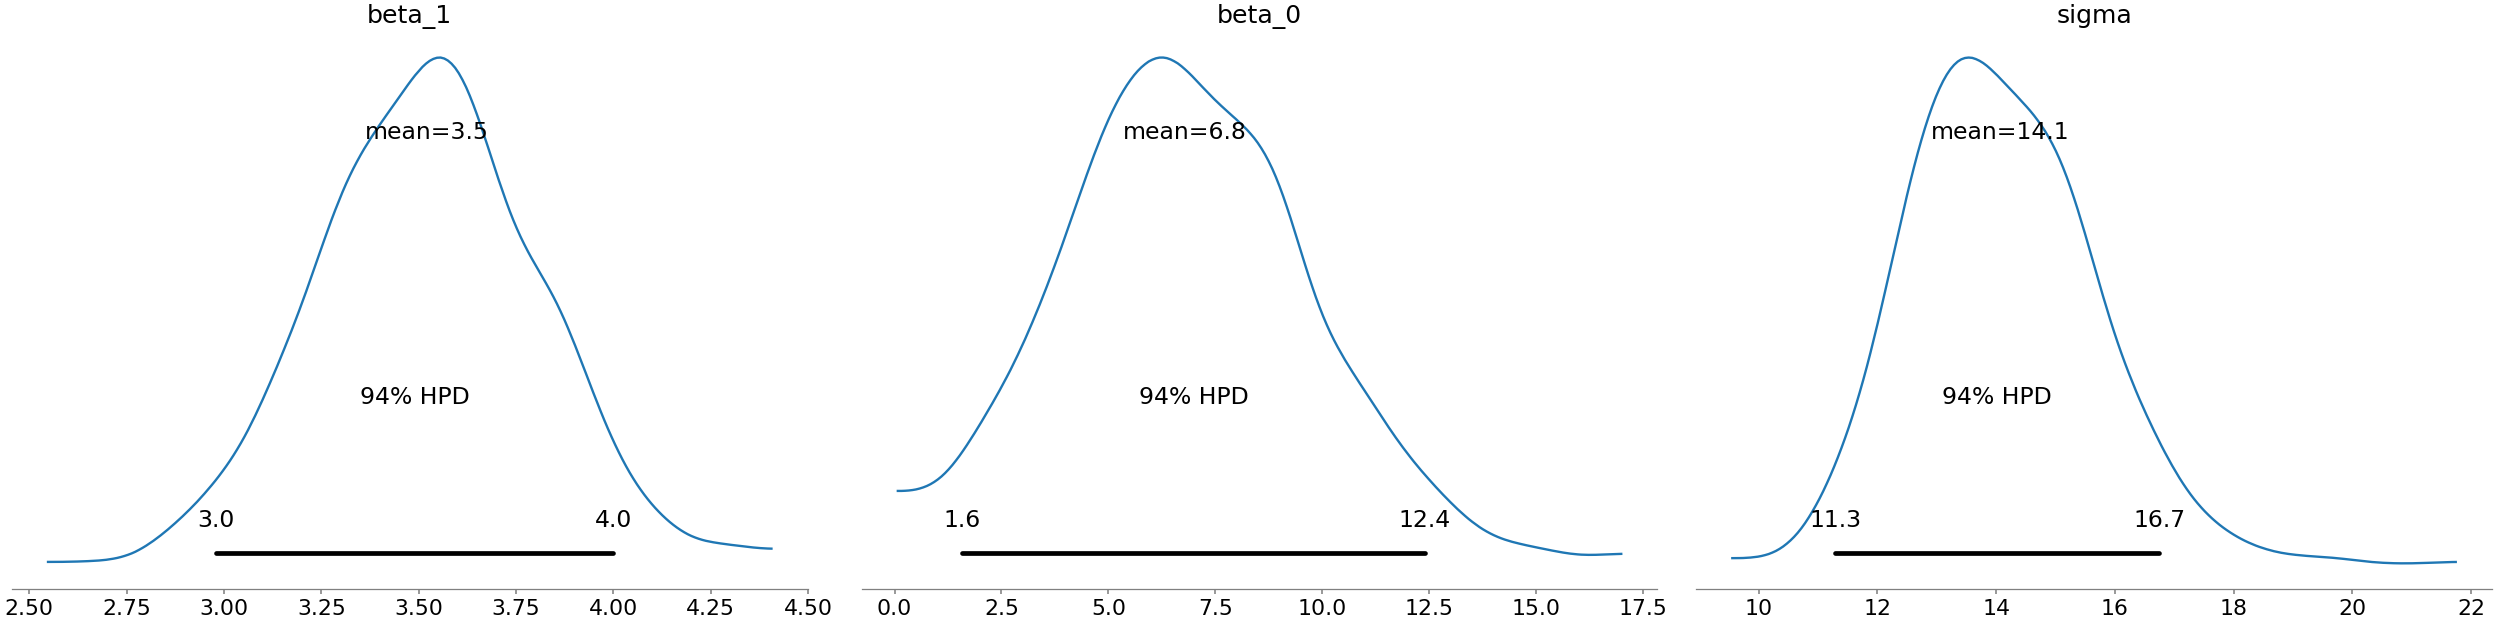

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000032427048>,
      dtype=object)

In [92]:
pm.plot_posterior(trace)

In [93]:
# Get some estimates of new data
xnew = np.linspace(0,50,100)

# Set the value of xin to do a prediction on new values 
xin.set_value(xnew)
with model:
    ppc = pm.sample_posterior_predictive(trace,samples=500)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 100.14it/s]


In [94]:
ppc['y_t'].shape

(500, 100)

<IPython.core.display.Javascript object>


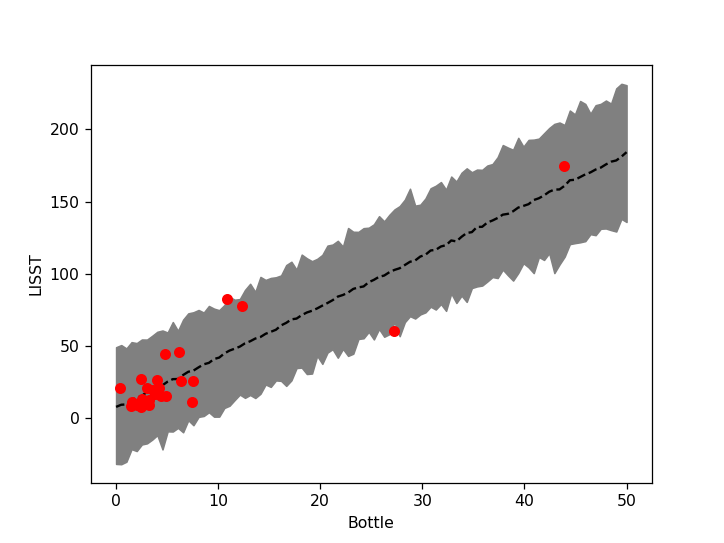

Text(0,0.5,'LISST')

In [95]:
# Plot the mean and 99% credible intervals of the prediction
y_mean = np.mean(ppc['y_t'],axis=0)
y_min = np.percentile(ppc['y_t'],0.5,axis=0)
y_max = np.percentile(ppc['y_t'],99.5,axis=0)

plt.figure()
plt.plot(xnew,y_mean,'k--')
plt.fill_between(xnew,y_min,y2=y_max,color='0.5')
plt.plot(x,y,'ro')
plt.xlabel('Bottle')
plt.ylabel('LISST')

# Define a model with zero lower bound

This is achieved using a positive definite distribution for the likelihood e.g., lognormal